This notebook will translate the format from mit .mat files to the hdf5 data structure and a .csv catalog. <br>
(It can also run specufex pre-, syn- and post-processing.) 

In [86]:
import numpy as np
import h5py as h5
import scipy.io as scio
import yaml
import pandas as pd
import os
import matplotlib.pyplot as plt

In [87]:
# defining the paths. 
base_path = '/media/ben/bup2020/ML_data/Tiange_NER/CO2pWater/'
path_to_wavemat = base_path + 'CO2pWater_AEs.mat'

# path to mechanical data-- actually don't need until after running specufex, and not for the "MCW" (Minimum common workpath)
#path_to_mechdata = base_path + 'dunno'

# read in the config file: 
# load config file
path_to_config = '/home/ben/DATA_tmp/mitAEs/waterCO2_1/config.yml'
with open(path_to_config, 'r') as cfigs:
    print(cfigs)
    try:
        config = yaml.safe_load(cfigs)
    except yaml.YAMLError as exc:
        print(exc)

# pull out config values for conciseness
path_config = config["paths"]
print(path_config)
projpath = path_config["projectPath"]
print(projpath)

<_io.TextIOWrapper name='/home/ben/DATA_tmp/mitAEs/waterCO2_1/config.yml' mode='r' encoding='UTF-8'>
{'key': 'mitAE_waterCO2_1', 'projectPath': '/home/ben/DATA_tmp/mitAEs/waterCO2_1/', 'pathCat': '/home/ben/DATA_tmp/mitAEs/waterCO2_1/wf_cat.csv', 'pathWF': '/home/ben/DATA_tmp/mitAEs/waterCO2_1/wavefiles_tmp/', 'h5name': 'mitAE_waterCO2_1.h5'}
/home/ben/DATA_tmp/mitAEs/waterCO2_1/


In [88]:
# load the mat file
#ae_waves = scio.loadmat(path_to_wavemat)

with h5.File(path_to_wavemat, 'r') as f:
    keys = list(f.keys())
    print(keys)
    print(np.shape(f['Time_AE']))
    print(type(f['Time_AE']))
    times = np.asarray(f['Time_AE']) # flatten (np.squeeze) this... 
    
# the data are registered in the field AE_CAT
# ae_cat = ae_cat['AE_CAT']

['AE_Channel_1', 'AE_Channel_2', 'AE_Channel_3', 'AE_Channel_4', 'AE_Channel_5', 'AE_Channel_6', 'AE_Channel_7', 'AE_Channel_8', 'Time_AE']
(8791, 1)
<class 'h5py._hl.dataset.Dataset'>


In [89]:
print(type(times))
times = np.squeeze(times)
print(np.shape(times))

# convert to integers
times_ints = times.astype(int)
print(times[0:5])
print(times_ints[0:5])


evID_stringlist = times_ints.astype(str)
print(evID_stringlist[0:5])


# new_list = [ item+1 for item in my_list ] : https://openwritings.net/pg/python/python-loop-square-brackets
filename_stringlist = [ev+'.txt' for ev in evID_stringlist]
print(filename_stringlist[0:5])
#filename_stringlist = filename_stringlist + '.txt'

<class 'numpy.ndarray'>
(8791,)
[77949154. 78839548. 79631317. 80246738. 80344463.]
[77949154 78839548 79631317 80246738 80344463]
['77949154' '78839548' '79631317' '80246738' '80344463']
['77949154.txt', '78839548.txt', '79631317.txt', '80246738.txt', '80344463.txt']


In [90]:
# Make a catalog in our standard format, using the start times as the event IDs and the filenames:
'''
ev_ID
  - The unique event ID for the waveform.  (SHOULD THIS BE A STRING OR INT?)
filename
  - The name of the file containing the waveform
timestamp
  - Timestamp in aribitrary units. Could be in datetime format, seconds, nanoseconds, etc, 
    but the only requirement is that it designates time as a number.
'''



cat_df = pd.DataFrame({"ev_ID":evID_stringlist,
                      "filename":filename_stringlist,
                      "timestamp":times})

print(cat_df)

outpath = projpath+'wf_cat.csv'
cat_df.to_csv(outpath, index=False)

           ev_ID        filename     timestamp
0       77949154    77949154.txt  7.794915e+07
1       78839548    78839548.txt  7.883955e+07
2       79631317    79631317.txt  7.963132e+07
3       80246738    80246738.txt  8.024674e+07
4       80344463    80344463.txt  8.034446e+07
...          ...             ...           ...
8786  1146819396  1146819396.txt  1.146819e+09
8787  1146822212  1146822212.txt  1.146822e+09
8788  1146908185  1146908185.txt  1.146908e+09
8789  1147110925  1147110925.txt  1.147111e+09
8790  1147143476  1147143476.txt  1.147143e+09

[8791 rows x 3 columns]


## GET WAVEFORMS INTO h5
(1) WRITE THE INDIVIDUAL WAVEFORMS TO A DIRECTORY <br>
(2) RUN THE 1_makeWaveformsDataset.py <br>
(3) Delete the directory <br>

In [51]:
# extract the waveform matrix: 

with h5.File(path_to_wavemat, 'r') as f:
    keys = list(f.keys())
    print(keys)
    
    ae_ra = np.asarray(f['AE_Channel_1']) # 

arrayshape = np.shape(ae_ra)
# axis 0 = events, axis 1 = displacements
# i.e. each row is a waveform ! 



['AE_Channel_1', 'AE_Channel_2', 'AE_Channel_3', 'AE_Channel_4', 'AE_Channel_5', 'AE_Channel_6', 'AE_Channel_7', 'AE_Channel_8', 'Time_AE']


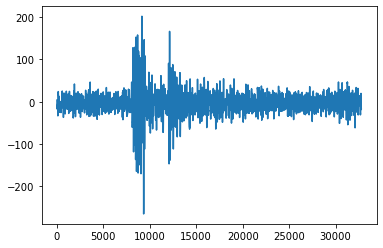

In [52]:
plt.plot(ae_ra[1000,:])

In [59]:
# write the temporary directory name in the directory where the original .mat data files are (even if on an external drive)
# or can be in the project_path
xlist = os.listdir(projpath)
print(xlist)

temp_dir = projpath + 'wavefiles_tmp/'
print(temp_dir)

try: 
    os.mkdir(temp_dir)
except:
    print('the directory already exists... got a good reason to overwrite it? then delete it !')

xlist = os.listdir(projpath)
print(xlist)
os.listdir(temp_dir)


['config.yml', 'config_tmp.yml', 'wf_cat.csv', 'mat_to_h5_ebauce.py']
/home/ben/DATA_tmp/mitAEs/wavefiles_tmp/
['wavefiles_tmp', 'config.yml', 'config_tmp.yml', 'wf_cat.csv', 'mat_to_h5_ebauce.py']


[]

In [60]:
# create the files ! 

# https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html
# numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
n_files = arrayshape[0]
print(n_files)

for i in range(n_files):
    wav = ae_ra[i,:]
    filepathtmp = temp_dir + filename_stringlist[i]
    np.savetxt(filepathtmp,wav)
    if i%1000 == 0:
        print(str(i)+' of '+str(n_files))
    
flist = os.listdir(temp_dir)
print(flist[0:5])
print(len(flist))

8791
0 of 8791
100 of 8791
200 of 8791
300 of 8791
400 of 8791
500 of 8791
600 of 8791
700 of 8791
800 of 8791
900 of 8791
1000 of 8791
1100 of 8791
1200 of 8791
1300 of 8791
1400 of 8791
1500 of 8791
1600 of 8791
1700 of 8791
1800 of 8791
1900 of 8791
2000 of 8791
2100 of 8791
2200 of 8791
2300 of 8791
2400 of 8791
2500 of 8791
2600 of 8791
2700 of 8791
2800 of 8791
2900 of 8791
3000 of 8791
3100 of 8791
3200 of 8791
3300 of 8791
3400 of 8791
3500 of 8791
3600 of 8791
3700 of 8791
3800 of 8791
3900 of 8791
4000 of 8791
4100 of 8791
4200 of 8791
4300 of 8791
4400 of 8791
4500 of 8791
4600 of 8791
4700 of 8791
4800 of 8791
4900 of 8791
5000 of 8791
5100 of 8791
5200 of 8791
5300 of 8791
5400 of 8791
5500 of 8791
5600 of 8791
5700 of 8791
5800 of 8791
5900 of 8791
6000 of 8791
6100 of 8791
6200 of 8791
6300 of 8791
6400 of 8791
6500 of 8791
6600 of 8791
6700 of 8791
6800 of 8791
6900 of 8791
7000 of 8791
7100 of 8791
7200 of 8791
7300 of 8791
7400 of 8791
7500 of 8791
7600 of 8791
7700 o

In [92]:
# construct the command to run the script
abspath_script = '/home/ben/githole/specufex_processing/1_preprocessing/1_makeWaveformsDataset.py'
relpath_script = '../1_preprocessing/1_makeWaveformsDataset.py'
localpath_script = '1_makeWaveformsDataset.py'
cmd = 'python ' + localpath_script +' '+ path_to_config
print(cmd)


python 1_makeWaveformsDataset.py /home/ben/DATA_tmp/mitAEs/waterCO2_1/config.yml


In [66]:
# RUN the script to make the h5 ! 
# Do it here from the notebook, using a method below,  
# OR just copy the cmd from the output of the box above and run it in a terminal, 
# especially if you did not launch this notebook in the same environment that contains obspy


# https://janakiev.com/blog/python-shell-commands/
# this works but returns no output: os.system(cmd)

#stream = os.popen(cmd)
#output = stream.read()
#print(output) # this does NOT work ! you have to look in the terminal where you launched the notebook to see this. 

#import subprocess
# better to use subprocess.run : 
# https://docs.python.org/3/library/subprocess.html#subprocess.run



In [97]:
# test the h5 ! 
h5list = os.listdir(projpath+'H5files/')
print(h5list)

['data_mitAE_waterCO2_1.h5']


dict_keys(['network', 'station', 'channel', 'channel_ID', 'sampling_rate', 'filetype', 'cat_columns'])
50000000


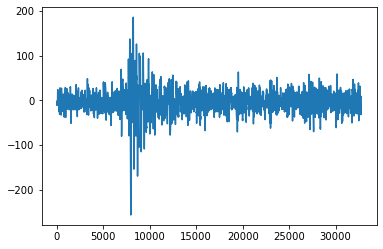

In [102]:
config["dataParams"].keys()
data_config = config["dataParams"]
print(data_config.keys())
station = data_config["station"]
channel = data_config["channel"]
wavenametest = evID_stringlist[27]

dataH5_path = projpath+'H5files/' + h5list[0]
with h5.File(dataH5_path,'r') as h5file:
    fs =  h5file[f"{station}/processing_info"].get('sampling_rate_Hz')[()]
    testwav = h5file[f"/waveforms/{station}/{channel}/{wavenametest}"][()]
    
print(fs)
plt.plot(testwav)



In [104]:
# DELETE the temporary directory of all the individual waveforms... 

cmddel = 'rm -r ' + temp_dir
print(cmddel) 
# copy and run from terminal... 

rm -r /home/ben/DATA_tmp/mitAEs/wavefiles_tmp/
